# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

Let's start by importing the required dependencies.

In [1]:
import os
import sys 
import torch
import platform
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import DataLoader

# Importing the custom modules
import custom_library as cl
from topic_list import count_keywords, create_class_files, load_data

Then we chose the optimal computation configuration depending on the operatin system.

In [2]:
# Check is at least python 3.9
assert (sys.version_info.major == 3) and (sys.version_info.minor > 9)

# Get os name
os_name = platform.system().lower()

# OS X
if 'darwin' in os_name:
    num_workers = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Set the device to mps (Apple Silicon GPU) if availaible for faster computation
    print("Detected OS X, device set to:", device)
# Linux 
elif 'linux' in os_name:
    device = torch.device("cpu")
    num_workers = 8
    print("Detected Linux, device set to:", device) 
# Windows 
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 0
    print("Detected Windows, device set to:", device)

Detected OS X, device set to: mps


## Generation of the custom datasets

First, let's search for the populations that are the most frequently represented and targetted by the memes in the dataset. In this project we will now refer to a population as a topic. We define a function that will count the number of occurences of each keyword associated with a topic in the dataset.

In [3]:
# Define the directory paths
destination_dir  = "hateful_memes/"
train_json       = "hateful_memes/train.jsonl"
test_seen_json   = "hateful_memes/test_seen.jsonl"
test_unseen_json = "hateful_memes/test_unseen.jsonl"
img_path         = 'hateful_memes/img'

keywords = {
    "Africans" : ["black", "white", "afro", "african", "ebony", "panafrican", "afroamerican", "nubian", "melanin", "slave", "slavery", "field", "cotton"],
    "Womens"   : ["woman", "she", "her", "female", "feminine", "lady", "girl", "feminist", "queen", "mother", "daughter"],
    "Muslims"  : ["muslim", "arab", "coran", "islam", "islamic", "muslimah", "hijab", "sunni", "shiite", "halal", "mosque", "goat", "habibi"],
    "LGBTQ"    : ["lgbt", "gay", "homo", "lesbian", "bisexual", "transgender", "queer", "pride", "rainbow", "drag", "trans", "nonbinary"],
    "Jews"     : ["jewish", "jew", "hebrew", "israeli", "yiddish", "semitic", "kosher", "rabbi"],
    "Politics" : ["activist", "protest", "demonstration", "rally", "activism", "campaign", "cause", "resist", "justice", "rights"],
    "Asians"   : ["asian", "chinese", "oriental", "eastasian", "japanese", "korean", "vietnamese", "filipino", "anime", "manga"],
    "Disable"  : ["disabled", "retarded", "handicap", "disability", "impaired", "specialneeds", "wheelchair", "autism", "dyslexia"],
    "Homeless" : ["homeless", "poor", "beggar", "vagrant", "homelessness", "poverty", "shelter", "unemployed", "panhandler"],
    "Natives " : ["indigenous", "nativeamerican", "firstnations", "aboriginal", "tribal", "native", "reservation", "tribe"],
    "Latinos " : ["latino", "hispanic", "chicano", "mestizo", "latina", "latinx", "boricua", "tejano"],
}

# The topics are returned in decreasing order of representation in the dataset
count_keywords(train_json, keywords, verbosity = 1);
count_keywords(test_unseen_json, keywords, verbosity = 1);

File: train.jsonl
Africans:  688  Harm Rate:  5.28%  Label 0:  239  Label 1:  449
Womens  :  524  Harm Rate:  2.39%  Label 0:  321  Label 1:  203
Muslims :  448  Harm Rate:  3.40%  Label 0:  159  Label 1:  289
LGBTQ   :  150  Harm Rate:  1.33%  Label 0:  37   Label 1:  113
Jews    :  100  Harm Rate:  0.82%  Label 0:  30   Label 1:  70
Politics:  62   Harm Rate:  0.29%  Label 0:  37   Label 1:  25
Asians  :  60   Harm Rate:  0.45%  Label 0:  22   Label 1:  38
Disable :  46   Harm Rate:  0.44%  Label 0:  9    Label 1:  37
Homeless:  31   Harm Rate:  0.14%  Label 0:  19   Label 1:  12
Natives :  15   Harm Rate:  0.05%  Label 0:  11   Label 1:  4
Latinos :  1    Harm Rate:  0.01%  Label 0:  0    Label 1:  1
File: test_unseen.jsonl
Africans:  104  Harm Rate:  3.05%  Label 0:  43   Label 1:  61
Womens  :  102  Harm Rate:  2.20%  Label 0:  58   Label 1:  44
Muslims :  61   Harm Rate:  1.45%  Label 0:  32   Label 1:  29
LGBTQ   :  22   Harm Rate:  0.55%  Label 0:  11   Label 1:  11
Jews    :  

We set the minimum number of memes for a topic to become a class to 300. Thus, only the topics "African", "Womens" and "Muslims" are kept as class. We can now generate new custom .jsonl files.

In [4]:
generate_new_files = False
if generate_new_files:
    create_class_files(train_json, count_keywords(train_json, keywords, verbosity = 0), destination_dir, "train");
    create_class_files(test_unseen_json, count_keywords(test_unseen_json, keywords, verbosity = 0), destination_dir, "test");

We can re-run the count_keywords function to have an idea of the new datatset:

In [5]:
refined_keywords = { "Africans" : ["black", "white", "afro", "african", "ebony", "panafrican", "afroamerican", "nubian", "melanin", "slave", "slavery", "field", "cotton"],
                     "Womens"  : ["woman", "she", "her", "female", "feminine", "lady", "girl", "feminist", "queen", "mother", "daughter"],
                     "Muslims" : ["muslim", "arab", "coran", "islam", "islamic", "muslimah", "hijab", "sunni", "shiite", "halal", "mosque", "goat", "habibi"], }

count_keywords("hateful_memes/Base_train.jsonl", refined_keywords, verbosity = 1);
count_keywords("hateful_memes/Base_test.jsonl", refined_keywords, verbosity = 1);

count_keywords("hateful_memes/Africans_train.jsonl", {"Africans":refined_keywords["Africans"]}, verbosity = 1);
count_keywords("hateful_memes/Africans_val.jsonl", {"Africans":refined_keywords["Africans"]}, verbosity = 1);
count_keywords("hateful_memes/Africans_test.jsonl", {"Africans":refined_keywords["Africans"]}, verbosity = 1);

count_keywords("hateful_memes/Womens_train.jsonl", {"Womens":refined_keywords["Womens"]}, verbosity = 1);
count_keywords("hateful_memes/Womens_val.jsonl", {"Womens":refined_keywords["Womens"]}, verbosity = 1);
count_keywords("hateful_memes/Womens_test.jsonl", {"Womens":refined_keywords["Womens"]}, verbosity = 1);

count_keywords("hateful_memes/Muslims_train.jsonl", {"Muslims":refined_keywords["Muslims"]}, verbosity = 1);
count_keywords("hateful_memes/Muslims_val.jsonl", {"Muslims":refined_keywords["Muslims"]}, verbosity = 1);
count_keywords("hateful_memes/Muslims_test.jsonl", {"Muslims":refined_keywords["Muslims"]}, verbosity = 1);

File: Base_train.jsonl
Africans:  542  Harm Rate:  13.01%  Label 0:  228  Label 1:  314
Womens  :  422  Harm Rate:  5.80%  Label 0:  282  Label 1:  140
Muslims :  367  Harm Rate:  8.20%  Label 0:  169  Label 1:  198
File: Base_test.jsonl
Africans:  104  Harm Rate:  12.03%  Label 0:  43   Label 1:  61
Womens  :  102  Harm Rate:  8.09%  Label 0:  61   Label 1:  41
Muslims :  61   Harm Rate:  5.52%  Label 0:  33   Label 1:  28
File: Africans_train.jsonl
Africans:  549  Harm Rate:  33.27%  Label 0:  183  Label 1:  366
File: Africans_val.jsonl
Africans:  139  Harm Rate:  30.07%  Label 0:  56   Label 1:  83
File: Africans_test.jsonl
Africans:  104  Harm Rate:  29.33%  Label 0:  43   Label 1:  61
File: Womens_train.jsonl
Womens  :  418  Harm Rate:  17.30%  Label 0:  273  Label 1:  145
File: Womens_val.jsonl
Womens  :  106  Harm Rate:  17.62%  Label 0:  69   Label 1:  37
File: Womens_test.jsonl
Womens  :  102  Harm Rate:  20.10%  Label 0:  61   Label 1:  41
File: Muslims_train.jsonl
Muslims : 

## Load the image captioning dataset

Let's load the images, with their labels and caption.

In [6]:
topics = ['Base', 'Africans', 'Womens', 'Muslims']
models = ['CLIP', 'BLIP', 'ALIGN']

train_list_B, validation_list_B, test_list_B = [], [], []
train_list_A, validation_list_A, test_list_A = [], [], []
train_list_W, validation_list_W, test_list_W = [], [], []
train_list_M, validation_list_M, test_list_M = [], [], []

for topic in topics: 
    train_json_path      = f'hateful_memes/{topic}_train.jsonl'
    validation_json_path = f'hateful_memes/{topic}_val.jsonl'
    test_json_path       = f'hateful_memes/{topic}_test.jsonl'

    # Get the first letter of the topic
    topic_initial = topic[0]

    # Use locals to access the correct list based on the topic
    load_data(train_json_path, locals()[f'train_list_{topic_initial}'], img_path)
    load_data(validation_json_path, locals()[f'validation_list_{topic_initial}'], img_path)
    load_data(test_json_path, locals()[f'test_list_{topic_initial}'], img_path)

Loaded 2414 memes from e_train.jsonl
Loaded 604 memes from e_val.jsonl
Loaded 507 memes from e_test.jsonl
Loaded 1100 memes from icans_train.jsonl
Loaded 276 memes from icans_val.jsonl
Loaded 208 memes from icans_test.jsonl
Loaded 838 memes from ens_train.jsonl
Loaded 210 memes from ens_val.jsonl
Loaded 204 memes from ens_test.jsonl
Loaded 716 memes from lims_train.jsonl
Loaded 180 memes from lims_val.jsonl
Loaded 122 memes from lims_test.jsonl


Let's retrieve the caption and the corresponding image for each of our 3 topics:

Topic: Base - Caption: how i see a gorilla when hes 100 years old - Label: 0
Topic: Africans - Caption: white people is this a shooting range? - Label: 0
Topic: Womens - Caption: if you're protesting against this man visiting the uk. ...but protesting for this woman to return to the uk.. ...then you're a special kind of stupid - Label: 0
Topic: Muslims - Caption: whatever this is... it's an auburn fan - Label: 0


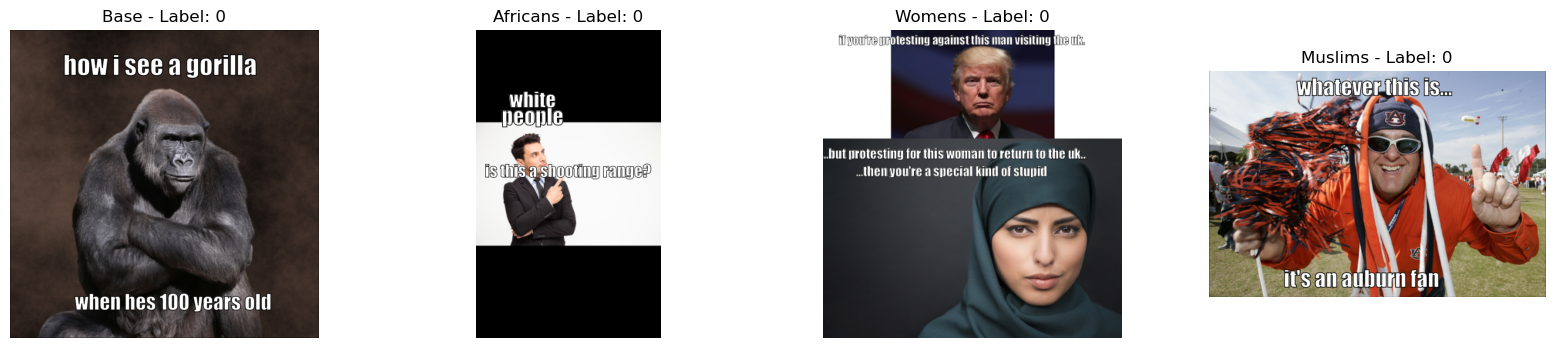

In [7]:
fig, axs = plt.subplots(1, len(topics), figsize=(20, 4))

for i, topic in enumerate(topics): 
    topic_initial = topic[0]
    print(f"Topic: {topic} - Caption: {locals()[f'train_list_{topic_initial}'][0]["text"]} - Label: {locals()[f'train_list_{topic_initial}'][0]["label"]}")
    axs[i].imshow(locals()[f'train_list_{topic_initial}'][0]["image"])
    axs[i].set_title(f"{topic} - Label: {locals()[f'train_list_{topic_initial}'][0]['label']}")
    axs[i].axis('off')

plt.show()

## Initialization of the Models

In [8]:
# Use this list to decide which model to use
model_selection = ['CLIP']
# Use this list to decide which topics to use
topic_selection = ['Muslims']

CLIP_A, CLIP_A, CLIP_W, CLIP_M     = None, None, None, None
BLIP_B, BLIP_A, BLIP_W, BLIP_M     = None, None, None, None
ALIGN_B, ALIGN_A, ALIGN_W, ALIGN_M = None, None, None, None
CLIP_processor, BLIP_processor, ALIGN_processor = None, None, None

for model in model_selection:
    print(f"Creating {model} models...")

    if model == 'CLIP':

        from transformers import CLIPProcessor, CLIPModel

        for topic in topic_selection:

            topic_initial = topic[0]

            # Create a pretrained CLIP model
            locals()[f'CLIP_{topic_initial}'] = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
            CLIP_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

            locals()[f'CLIP_{topic_initial}'] = cl.create_model(model_name=model, model=locals()[f'CLIP_{topic_initial}'], topic_initial=topic_initial, device=device)

    
    elif model == 'BLIP':
            
            from transformers import AutoProcessor, BlipForConditionalGeneration
    
            for topic in topic_selection:

                topic_initial = topic[0]

                # Create a pretrained BLIP model
                locals()[f'BLIP_{topic_initial}'] = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
                BLIP_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

                locals()[f'BLIP_{topic_initial}'] = cl.create_model(model_name=model, model=locals()[f'BLIP_{topic_initial}'], topic_initial=topic_initial, device=device)
    
    elif model == 'ALIGN':

        from transformers import AlignProcessor, AlignModel

        for topic in topic_selection:

            topic_initial = topic[0]

            # Create a pretrained ALIGN model
            locals()[f'ALIGN_{topic_initial}'] = AlignModel.from_pretrained("kakaobrain/align-base")
            ALIGN_processor = AlignProcessor.from_pretrained("kakaobrain/align-base")

            locals()[f'ALIGN_{topic_initial}'] = cl.create_model(model_name=model, model=locals()[f'ALIGN_{topic_initial}'], topic_initial=topic_initial, device=device)

Creating CLIP models...
Succesfully created CLIP_M.


We can save the models and display their architecture if wanted:

In [9]:
save = False
if save:
    # Save the model paramters to estimate the size of the model: CLIP = 605 MB, BLIP = 990 MB, VBert = 445 MB, ALIGN = 690 MB
    for model in model_selection:
        torch.save(locals()[f'{model}_B'], f"{model}_B.pth")
        # Display the model summary
        #(C, H, W): number of channels (C), height (H), and width (W) of the input image.
        input_size = (3, 224, 224) 
        summary(locals()[f'{model}_B'], input_size)

## Load model and processor

Now that we have loaded the models and their processor, let's load the dataset and the dataloader:

In [10]:
CLIP_train_loader_B, CLIP_validation_loader_B, CLIP_test_loader_B = None, None, None
CLIP_train_loader_A, CLIP_validation_loader_A, CLIP_test_loader_A = None, None, None
CLIP_train_loader_W, CLIP_validation_loader_W, CLIP_test_loader_W = None, None, None
CLIP_train_loader_M, CLIP_validation_loader_M, CLIP_test_loader_M = None, None, None

BLIP_train_loader_B, BLIP_validation_loader_B, BLIP_test_loader_B = None, None, None
BLIP_train_loader_A, BLIP_validation_loader_A, BLIP_test_loader_A = None, None, None
BLIP_train_loader_W, BLIP_validation_loader_W, BLIP_test_loader_W = None, None, None
BLIP_train_loader_M, BLIP_validation_loader_M, BLIP_test_loader_M = None, None, None

ALIGN_train_loader_B, ALIGN_validation_loader_B, ALIGN_test_loader_B = None, None, None
ALIGN_train_loader_A, ALIGN_validation_loader_A, ALIGN_test_loader_A = None, None, None
ALIGN_train_loader_W, ALIGN_validation_loader_W, ALIGN_test_loader_W = None, None, None
ALIGN_train_loader_M, ALIGN_validation_loader_M, ALIGN_test_loader_M = None, None, None

for model in model_selection:
    for topic in topics:
        
        topic_initial = topic[0]
        # Build the train and validation datasets
        train_dataset      = cl.ImageCaptioningDataset(locals()[f'train_list_{topic_initial}'], locals()[f'{model}_processor'])
        validation_dataset = cl.ImageCaptioningDataset(locals()[f'validation_list_{topic_initial}'], locals()[f'{model}_processor'])
        test_dataset       = cl.ImageCaptioningDataset(locals()[f'test_list_{topic_initial}'], locals()[f'{model}_processor'])

        # Create loaders
        locals()[f'{model}_train_loader_{topic_initial}']      = DataLoader(train_dataset,      batch_size=32, shuffle=True,  num_workers=num_workers, collate_fn = cl.collate_fn)
        locals()[f'{model}_validation_loader_{topic_initial}'] = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=num_workers, collate_fn = cl.collate_fn)
        locals()[f'{model}_test_loader_{topic_initial}']       = DataLoader(test_dataset,       batch_size=32, shuffle=False, num_workers=num_workers, collate_fn = cl.collate_fn)

    print(f"Succesfully created loaders for model {model}.")

Succesfully created loaders for model CLIP.


## Training the models

Let's train our models! Run the simply the cell below for training them.

Training CLIP_M for 6 epochs...
Epoch 1 - F1: 0.419 - Validation Loss: 0.595 - Training Loss: 0.402 - LR: 0.000500
Epoch 2 - F1: 0.772 - Validation Loss: 0.452 - Training Loss: 0.574 - LR: 0.000500
Epoch 3 - F1: 0.419 - Validation Loss: 0.495 - Training Loss: 0.590 - LR: 0.000500
Epoch 4 - F1: 0.713 - Validation Loss: 0.454 - Training Loss: 0.478 - LR: 0.000500
Epoch 5 - F1: 0.732 - Validation Loss: 0.448 - Training Loss: 0.345 - LR: 0.000500
Epoch 6 - F1: 0.732 - Validation Loss: 0.451 - Training Loss: 0.387 - LR: 0.000500
Best CLIP_M at epoch 2 -> 77.21% F1 score


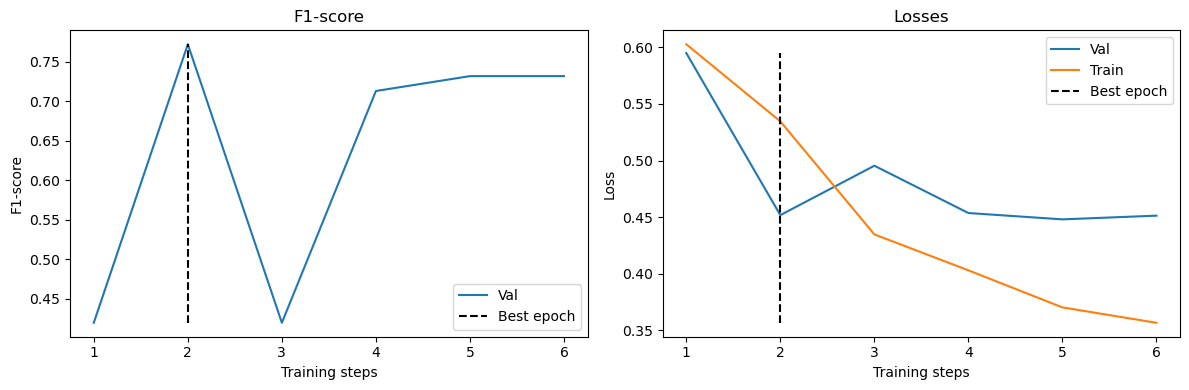

In [11]:
training_active = True
plot_training = True

try:
    for model in model_selection:
        for topic in topic_selection:
            topic_initial = topic[0]
            if training_active:
        
                locals()[f'{model}_{topic_initial}'].train()

                optimizer = torch.optim.AdamW(locals()[f'{model}_{topic_initial}'].parameters(), lr=5e-4)

                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

                epochs = 6

                print(f"Training {model}_{topic_initial} for {epochs} epochs...")
                best_model, best_f1, best_epoch, val_accs, val_loss, train_loss = cl.train(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_train_loader_{topic_initial}'], locals()[f'{model}_validation_loader_{topic_initial}'], n_epochs=epochs, optimizer=optimizer, device=device, scheduler=scheduler)
                print(f"Best {model}_{topic_initial} at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

                if plot_training:
                    cl.plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss)
                    plt.savefig(f'{model}/{model}_{topic_initial}_training.png')       # save the plot

                torch.save(best_model, f'{model}/{model}_{topic_initial}_trained.pth') # Save the state dictionary
                locals()[f'{model}_{topic_initial}'].eval();                           # Set the model to evaluation mode

            else:
                # Check if the file exists before trying to load it
                if os.path.exists(f'{model}/{model}_{topic_initial}_trained.pth'):
                    if model == 'CLIP':
                        locals()[f'CLIP_{topic_initial}'] = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
                        locals()[f'CLIP_{topic_initial}'] = cl.ModelForClassification(locals()[f'CLIP_{topic_initial}'])
                    elif model == 'BLIP':
                        locals()[f'BLIP_{topic_initial}'] = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
                        locals()[f'BLIP_{topic_initial}'] = cl.ModelForClassification(locals()[f'BLIP_{topic_initial}'])
                    elif model == 'ALIGN':
                        locals()[f'ALIGN_{topic_initial}'] = AlignModel.from_pretrained("kakaobrain/align-base")
                        locals()[f'ALIGN_{topic_initial}'] = cl.ModelForClassification(locals()[f'ALIGN_{topic_initial}'])

                    locals()[f'{model}_{topic_initial}'].load_state_dict(torch.load(f'{model}/{model}_{topic_initial}_trained.pth')) # Load the state_dict
                    locals()[f'{model}_{topic_initial}'].eval();                                                             # Set the model to evaluation mode
                    locals()[f'{model}_{topic_initial}'] = locals()[f'{model}_{topic_initial}'].to(device)                   # Move the model to the device   
                    print(f"Succesfully loaded saved weights for {model}_{topic_initial}.")
                else:
                    print(f"No pre-trained model found for {model}_{topic_initial}.")
                    locals()[f'{model}_{topic_initial}'] = None
except KeyboardInterrupt:
    print(f"Training interrupted. Saving {model}_{topic_initial} and outputs...")
    if plot_training:
        plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss)
        plt.savefig(f'{model}/{model}_{topic_initial}_training.png') # save the plot
    # Save the state dictionary
    torch.save(best_model, f'{model}_{topic_initial}_trained.pth')
    locals()[f'{model}_{topic_initial}'].eval();  # Set the model to evaluation mode

## Inference

Let's check the results on our validation set:

In [12]:
testing_performances = False

if testing_performances:
    for model in model_selection:
        for topic in topic_selection:
            topic_initial = topic[0]
            # check that the model is loaded correctly
            if locals()[f'{model}_{topic_initial}'] is not None:
                print(f"{model}_{topic_initial} F1 score on the training set: {100*cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_train_loader_{topic_initial}'], device)[0]:.2f}%")
                print(f"{model}_{topic_initial} F1 score on the validation set: {100*cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_validation_loader_{topic_initial}'], device)[0]:.2f}%")
                print(f"{model}_{topic_initial} F1 score on the testing set: {100*cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_test_loader_{topic_initial}'], device)[0]:.2f}%")

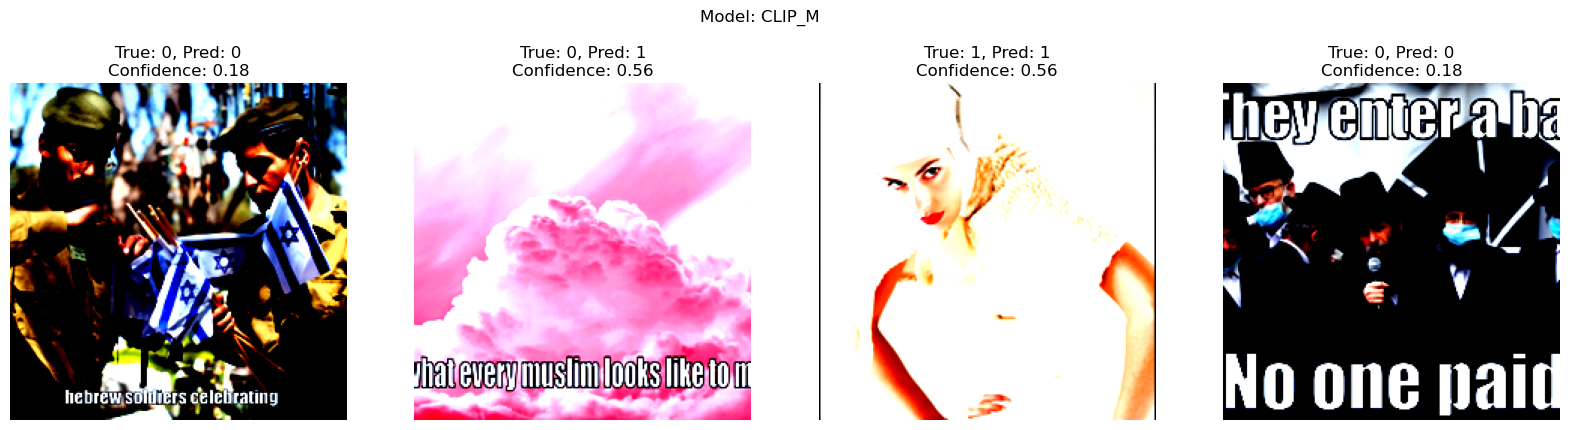

In [13]:
test_model_on_image = True

if test_model_on_image:
    for model in model_selection:
        for topic in topic_selection:
            topic_initial = topic[0]
            if locals()[f'{model}_{topic_initial}'] is not None:
                cl.predict_image2(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_test_loader_{topic_initial}'], device, index=np.random.randint(0, 28), model_name = model, topic_name = topic_initial)

## Ensemble Learning

In [14]:
ensemble_active = False

if ensemble_active:
    for model in model_selection:
        for topic in topic_selection:
            topic_initial = topic[0]
            # check that the model is loaded correctly
            if locals()[f'{model}_{topic_initial}'] is not None:
                f1, loss, confidence = cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_test_loader_B'], device, return_confidences=True)
                print(f"{model}_{topic_initial} F1 score on the Base test set: {100*f1:.2f}%")
                for i, c in enumerate(confidence):
                    print(f"Image {i} - Confidence: {c}")